In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# 12by12 Unimanual Representation

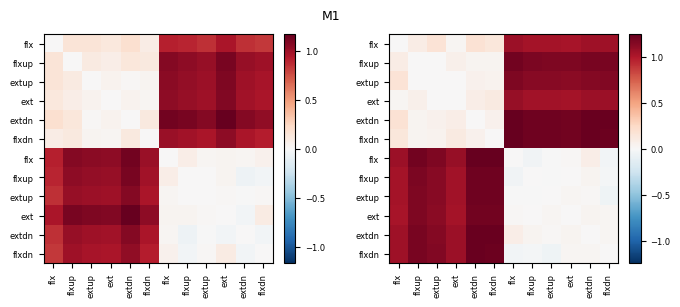

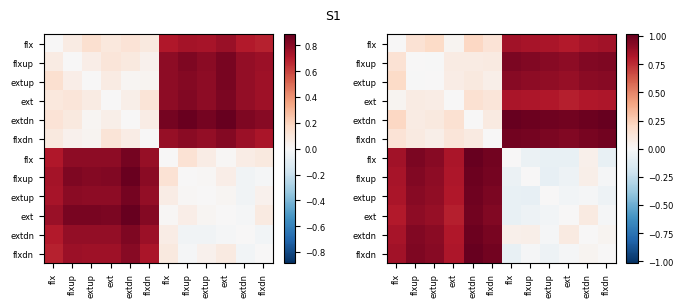

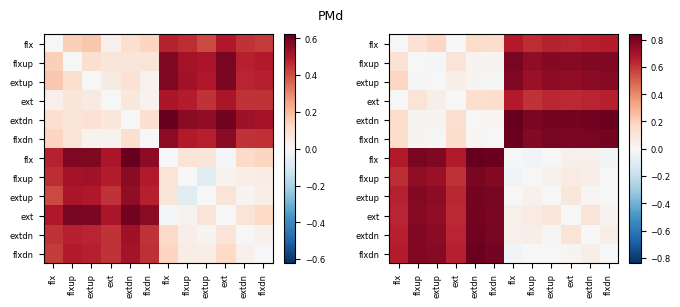

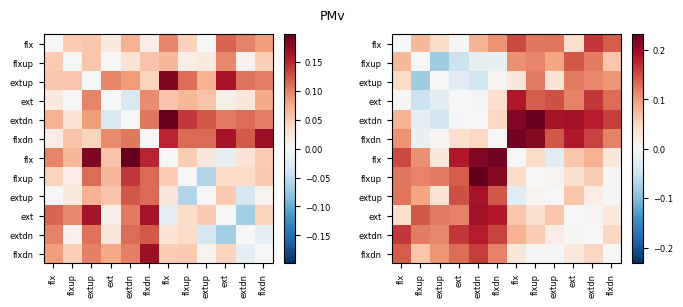

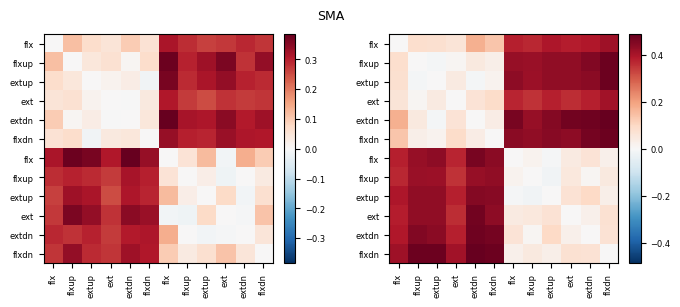

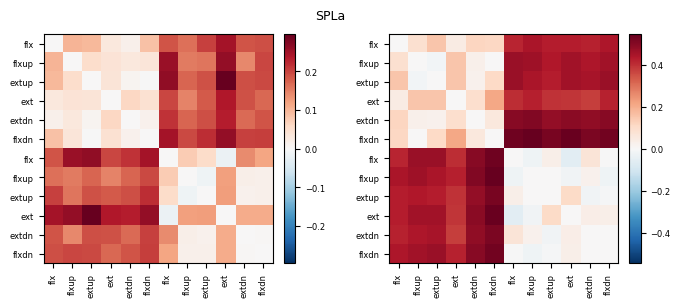

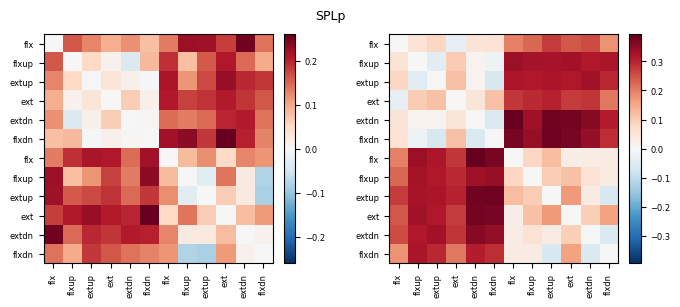

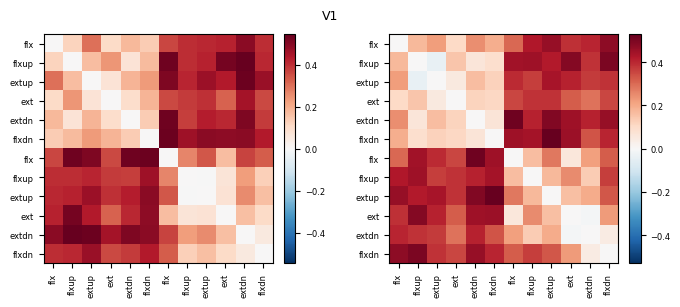

In [3]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

RDMs_unimanual = {'sn': [], 'region':[], 'hem':[], 'labels': [], 'G': [], 'D^2': []}

for i_region, region in enumerate(regions):
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_glmsingle_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)
        data, cond_vec, part_vec = [], [], []

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            Y = data_tmp[i_sub][idx, :]
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
        N = len(Y)
        ncond = 12
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            RDMs_unimanual['sn'].append(subject[i_sub])
            RDMs_unimanual['region'].append(region)
            RDMs_unimanual['hem'].append(h)
            RDMs_unimanual['labels'].append(labels)
            RDMs_unimanual['G'].append(G_hat[i_sub, :, :])
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            RDMs_unimanual['D^2'].append(dist)

RDMs_unimanual = pd.DataFrame(RDMs_unimanual)
RDMs_unimanual.to_pickle(os.path.join(analysisDir, 'RDMs_glmsingle_unimanual.pkl'))

# PLOT:
plt.rcParams.update({'font.size': 6})
cmap = 'RdBu_r'
for region in regions:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_L = np.mean(D, axis=0)

    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_R = np.mean(D, axis=0)

    fig, ax = plt.subplots(1,2, figsize=(7,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, d in enumerate([D_avg_L, D_avg_R]):
        plt.sca(ax[i])
        vmin = -np.max(np.abs(d))
        vmax = np.max(np.abs(d))
        im = ax[i].imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ax[i].set_xticks(np.arange(len(labels)))
        ax[i].set_yticks(np.arange(len(labels)))
        ax[i].set_xticklabels(labels)
        ax[i].set_yticklabels(labels)
        ax[i].set_xticks(list(range(len(labels))))
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_yticks(list(range(len(labels))))
        ax[i].set_yticklabels(labels)

    plt.tight_layout()
    plt.show()




# Is the sturcture similar across hemisphere?

M1 L2L:
    contra-contra: t=2.35, p=0.0382
    contra-ipsi: t=-1.66, p=0.1242
    ipsi-ipsi: t=2.33, p=0.0397
    ipsi-contra: t=0.17, p=0.8655
M1 L2R:
    contra-contra: t=3.29, p=0.0072
    contra-ipsi: t=-0.70, p=0.4959
    ipsi-ipsi: t=-0.36, p=0.7239
    ipsi-contra: t=-2.16, p=0.0535
M1 R2R:
    contra-contra: t=4.87, p=0.0005
    contra-ipsi: t=-0.44, p=0.6690
    ipsi-ipsi: t=-0.61, p=0.5557
    ipsi-contra: t=0.58, p=0.5762
M1 R2L:
    contra-contra: t=1.76, p=0.1058
    contra-ipsi: t=-6.47, p=0.0000
    ipsi-ipsi: t=-0.80, p=0.4382
    ipsi-contra: t=-0.07, p=0.9456


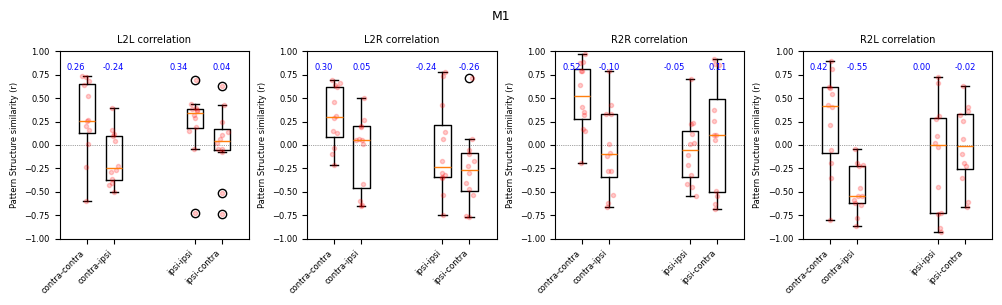

S1 L2L:
    contra-contra: t=1.18, p=0.2627
    contra-ipsi: t=-0.01, p=0.9920
    ipsi-ipsi: t=0.66, p=0.5200
    ipsi-contra: t=1.29, p=0.2251
S1 L2R:
    contra-contra: t=2.13, p=0.0569
    contra-ipsi: t=-0.07, p=0.9455
    ipsi-ipsi: t=-1.37, p=0.1989
    ipsi-contra: t=-0.13, p=0.8977
S1 R2R:
    contra-contra: t=4.33, p=0.0012
    contra-ipsi: t=1.12, p=0.2861
    ipsi-ipsi: t=0.15, p=0.8800
    ipsi-contra: t=0.58, p=0.5729
S1 R2L:
    contra-contra: t=1.51, p=0.1586
    contra-ipsi: t=-5.42, p=0.0002
    ipsi-ipsi: t=-1.20, p=0.2551
    ipsi-contra: t=-0.52, p=0.6158


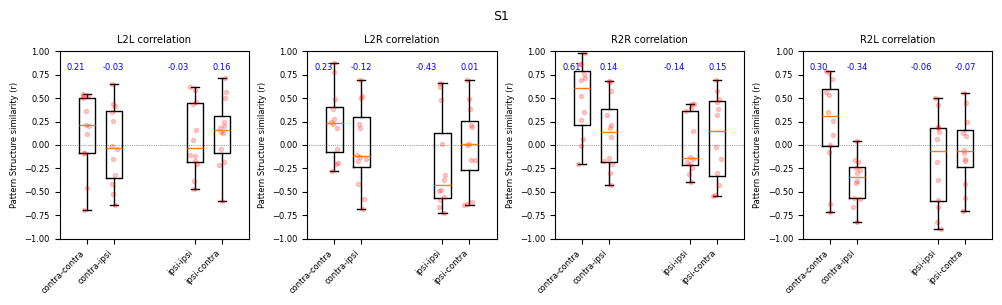

PMd L2L:
    contra-contra: t=4.30, p=0.0013
    contra-ipsi: t=-3.43, p=0.0056
    ipsi-ipsi: t=6.74, p=0.0000
    ipsi-contra: t=-4.25, p=0.0014
PMd L2R:
    contra-contra: t=5.40, p=0.0002
    contra-ipsi: t=0.04, p=0.9652
    ipsi-ipsi: t=-0.52, p=0.6114
    ipsi-contra: t=-6.37, p=0.0001
PMd R2R:
    contra-contra: t=6.74, p=0.0000
    contra-ipsi: t=0.13, p=0.8979
    ipsi-ipsi: t=1.18, p=0.2623
    ipsi-contra: t=-0.42, p=0.6859
PMd R2L:
    contra-contra: t=3.73, p=0.0033
    contra-ipsi: t=-7.53, p=0.0000
    ipsi-ipsi: t=-0.28, p=0.7875
    ipsi-contra: t=-0.76, p=0.4615


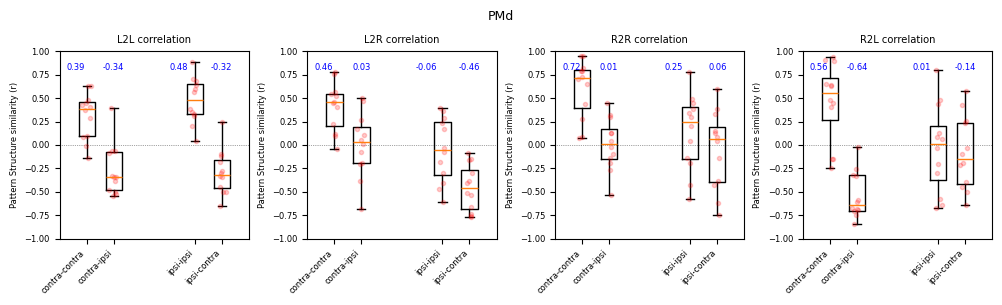

PMv L2L:
    contra-contra: t=2.23, p=0.0472
    contra-ipsi: t=1.85, p=0.0914
    ipsi-ipsi: t=-0.23, p=0.8214
    ipsi-contra: t=-0.01, p=0.9928
PMv L2R:
    contra-contra: t=3.02, p=0.0116
    contra-ipsi: t=0.23, p=0.8204
    ipsi-ipsi: t=1.42, p=0.1845
    ipsi-contra: t=-0.13, p=0.9019
PMv R2R:
    contra-contra: t=1.18, p=0.2644
    contra-ipsi: t=0.31, p=0.7633
    ipsi-ipsi: t=-1.33, p=0.2096
    ipsi-contra: t=0.49, p=0.6345
PMv R2L:
    contra-contra: t=3.22, p=0.0081
    contra-ipsi: t=-0.07, p=0.9449
    ipsi-ipsi: t=1.59, p=0.1395
    ipsi-contra: t=-0.29, p=0.7783


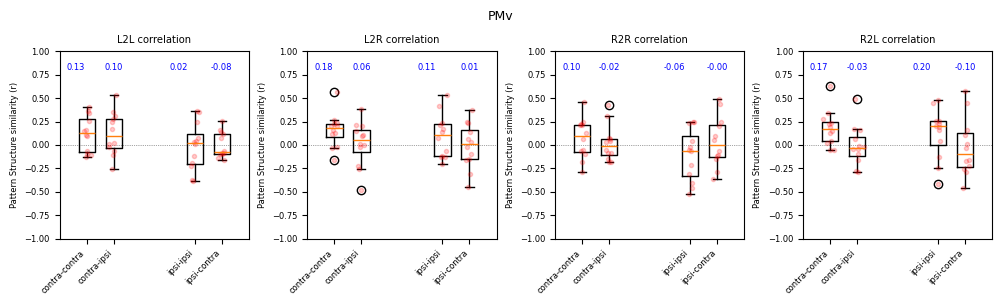

SMA L2L:
    contra-contra: t=0.53, p=0.6098
    contra-ipsi: t=-0.83, p=0.4220
    ipsi-ipsi: t=3.12, p=0.0097
    ipsi-contra: t=-0.95, p=0.3620
SMA L2R:
    contra-contra: t=1.99, p=0.0722
    contra-ipsi: t=1.45, p=0.1751
    ipsi-ipsi: t=-0.01, p=0.9917
    ipsi-contra: t=-2.40, p=0.0353
SMA R2R:
    contra-contra: t=2.48, p=0.0303
    contra-ipsi: t=2.46, p=0.0317
    ipsi-ipsi: t=-0.68, p=0.5131
    ipsi-contra: t=-0.18, p=0.8611
SMA R2L:
    contra-contra: t=3.19, p=0.0086
    contra-ipsi: t=-2.06, p=0.0642
    ipsi-ipsi: t=0.63, p=0.5428
    ipsi-contra: t=0.08, p=0.9399


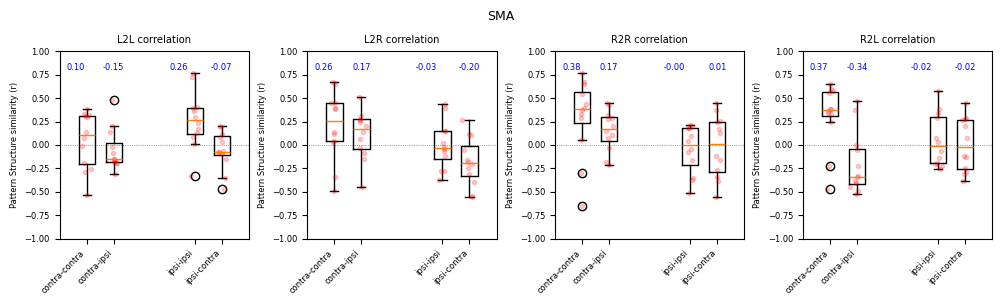

SPLa L2L:
    contra-contra: t=1.35, p=0.2031
    contra-ipsi: t=-0.34, p=0.7388
    ipsi-ipsi: t=3.35, p=0.0065
    ipsi-contra: t=-0.03, p=0.9758
SPLa L2R:
    contra-contra: t=1.90, p=0.0846
    contra-ipsi: t=1.04, p=0.3192
    ipsi-ipsi: t=1.33, p=0.2101
    ipsi-contra: t=-1.51, p=0.1580
SPLa R2R:
    contra-contra: t=6.75, p=0.0000
    contra-ipsi: t=0.88, p=0.3982
    ipsi-ipsi: t=-3.88, p=0.0026
    ipsi-contra: t=-0.59, p=0.5640
SPLa R2L:
    contra-contra: t=6.56, p=0.0000
    contra-ipsi: t=-3.20, p=0.0085
    ipsi-ipsi: t=1.15, p=0.2754
    ipsi-contra: t=-0.10, p=0.9209


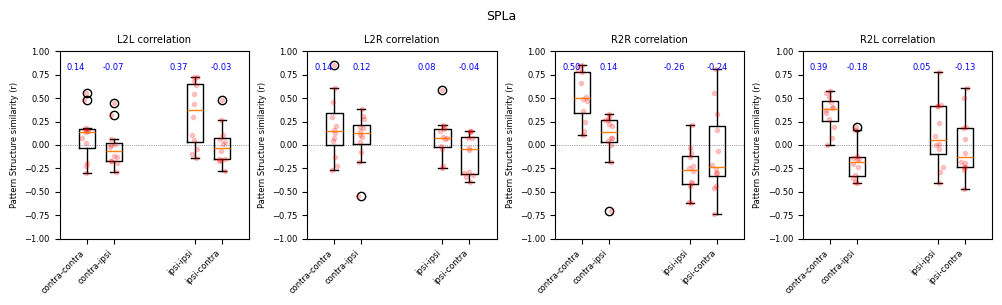

SPLp L2L:
    contra-contra: t=1.75, p=0.1078
    contra-ipsi: t=0.33, p=0.7466
    ipsi-ipsi: t=2.71, p=0.0205
    ipsi-contra: t=1.98, p=0.0736
SPLp L2R:
    contra-contra: t=0.94, p=0.3688
    contra-ipsi: t=0.50, p=0.6264
    ipsi-ipsi: t=3.35, p=0.0065
    ipsi-contra: t=1.29, p=0.2232
SPLp R2R:
    contra-contra: t=3.21, p=0.0083
    contra-ipsi: t=1.32, p=0.2141
    ipsi-ipsi: t=-0.15, p=0.8801
    ipsi-contra: t=-0.01, p=0.9939
SPLp R2L:
    contra-contra: t=1.56, p=0.1464
    contra-ipsi: t=1.15, p=0.2754
    ipsi-ipsi: t=2.63, p=0.0234
    ipsi-contra: t=0.85, p=0.4156


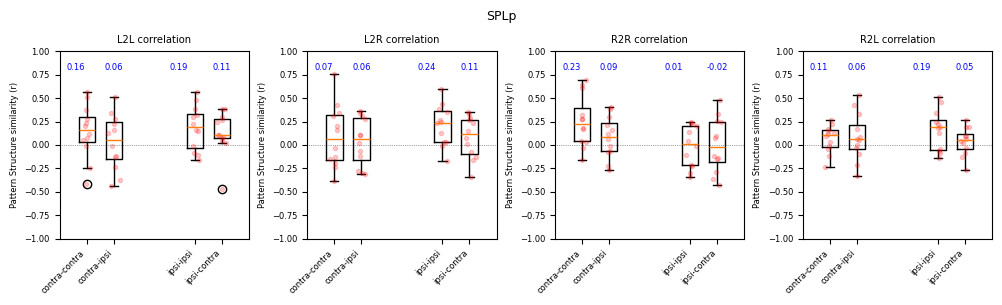

V1 L2L:
    contra-contra: t=3.46, p=0.0053
    contra-ipsi: t=4.56, p=0.0008
    ipsi-ipsi: t=5.91, p=0.0001
    ipsi-contra: t=2.61, p=0.0244
V1 L2R:
    contra-contra: t=5.49, p=0.0002
    contra-ipsi: t=3.43, p=0.0056
    ipsi-ipsi: t=3.00, p=0.0121
    ipsi-contra: t=4.03, p=0.0020
V1 R2R:
    contra-contra: t=2.60, p=0.0248
    contra-ipsi: t=3.28, p=0.0073
    ipsi-ipsi: t=3.77, p=0.0031
    ipsi-contra: t=3.73, p=0.0033
V1 R2L:
    contra-contra: t=5.32, p=0.0002
    contra-ipsi: t=3.30, p=0.0071
    ipsi-ipsi: t=3.69, p=0.0035
    ipsi-contra: t=3.36, p=0.0064


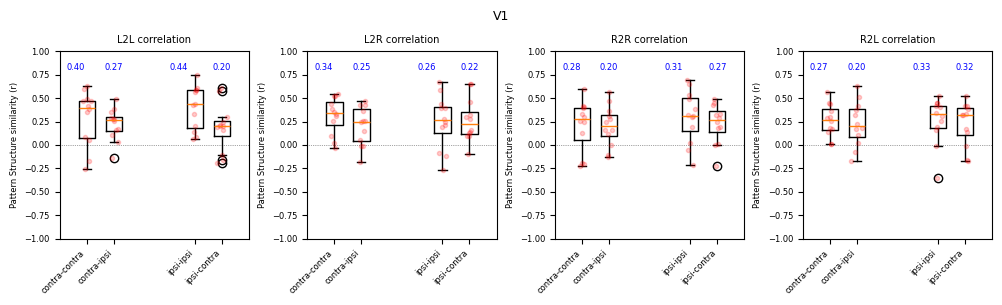

In [211]:
df = {'region': [], 'hem': [], 'within_hem': [], 'sn': [], 'r_contra_contra': [], 'r_ipsi_ipsi': [], 'r_contra_ipsi': [], 'r_ipsi_contra': []}

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']
for region in regions:
    # ============================= Within Hem =============================
    for i, h in enumerate(hem):
        tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']==h)]
        G = tmp['G'].to_list()
        G = np.array(G)
        # N-1 cross validation:
        N = np.shape(G)[0]
        r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
        for i in range(N):
            G_mean = np.mean(np.delete(G, i, axis=0), axis=0)
            # G_mean = pcm.G_to_dist(G_mean)
            G_sub = G[i, :, :]
            # G_sub = pcm.G_to_dist(G_sub)

            # imshow of G_mean and G_sub with subplots(1,2):
            # if region == 'PMd':
            #     cmap = 'RdBu_r'
            #     fig, ax = plt.subplots(1,2, figsize=(3.5,2))
            #     vmin = -np.max(np.abs(G_sub))
            #     vmax = np.max(np.abs(G_sub))
            #     ax[0].imshow(G_sub, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[0].set_title('G_sub')
            #     vmin = -np.max(np.abs(G_mean))
            #     vmax = np.max(np.abs(G_mean))
            #     ax[1].imshow(G_mean, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[1].set_title('G_mean')
            #     plt.suptitle(f'sn {tmp["sn"].values[i]} - {region}_{h}', fontsize=9)
            #     plt.tight_layout()
            #     plt.show()

            # contra-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[:6, :6]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_contra_contra.append(r)

            # ipsi-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[6:, 6:]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_ipsi_ipsi.append(r)

            # contra-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[:6, :6]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_contra_ipsi.append(r)

            # ipsi-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[6:, 6:]
            r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
            r_ipsi_contra.append(r)

        df['region'].append(region)
        df['hem'].append(f'{h}2{h}')
        df['within_hem'].append('within')
        df['sn'].append(list(tmp['sn']))
        df['r_contra_contra'].append(r_contra_contra)
        df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
        df['r_contra_ipsi'].append(r_contra_ipsi)
        df['r_ipsi_contra'].append(r_ipsi_contra)

        # also estimate full average corrleation:
        # G_mean = np.mean(G, axis=0)
        # G1 = G_mean[:6, :6] # contra
        # G2 = G_mean[6:, 6:] # ipsi
        # r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        # print(f'{region} {h} full average contra-ipsi correlation: r = {r:.2f}')
    
    # Between Hemisphere Correlation:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    G_L = tmp['G'].to_list()
    G_L = np.array(G_L)
    
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    G_R = tmp['G'].to_list()
    G_R = np.array(G_R)

    # ============================= L to R =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_R = np.mean(np.delete(G_R, i, axis=0), axis=0)
        # G_mean_R = pcm.G_to_dist(G_mean_R)
        G_sub_L = G_L[i, :, :]
        # G_sub_L = pcm.G_to_dist(G_sub_L)

        # contra-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('L2R')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)

    # ============================= R to L =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_L = np.mean(np.delete(G_L, i, axis=0), axis=0)
        # G_mean_L = pcm.G_to_dist(G_mean_L)
        G_sub_R = G_R[i, :, :]
        # G_sub_R = pcm.G_to_dist(G_sub_R)

        # contra-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[:6, :6]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[6:, 6:]
        r, _ = scipy.stats.pearsonr(G1[np.triu_indices(6, k=0)], G2[np.triu_indices(6, k=0)])
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('R2L')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)
df = pd.DataFrame(df)

# PLOT:
# In one box plot:
# First within hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
# Then between hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
plt.rcParams.update({'font.size': 6})
for region in regions:
    fig, ax = plt.subplots(1,4, figsize=(10,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, wh in enumerate(['L2L', 'L2R', 'R2R', 'R2L']):
        plt.sca(ax[i])
        tmp = df[(df['region']==region) & (df['hem']==wh)]
        r_contra_contra = tmp['r_contra_contra'].values[0]
        r_ipsi_ipsi = tmp['r_ipsi_ipsi'].values[0]
        r_contra_ipsi = tmp['r_contra_ipsi'].values[0]
        r_ipsi_contra = tmp['r_ipsi_contra'].values[0]
        data_plot = [r_contra_contra, r_contra_ipsi, r_ipsi_ipsi, r_ipsi_contra]
        ax[i].boxplot(data_plot, positions=[1,1.5,3,3.5], widths=0.3)
        ax[i].axhline(0, color='k', linestyle=':', linewidth=0.5, alpha=0.7)
        ax[i].set_xticks([1,1.5,3,3.5])
        ax[i].set_xticklabels(['contra-contra', 'contra-ipsi', 'ipsi-ipsi', 'ipsi-contra'], rotation=45, ha='right')
        ax[i].set_ylabel('Pattern Structure similarity (r)')
        ax[i].set_ylim([-1, 1])
        ax[i].set_title(f'{wh} correlation')
        # ax[i].set_yticks(np.arange(-0.1, 1.1, 0.2))

        # individual data points:
        for j in range(len(data_plot)):
            y = data_plot[j]
            x = np.random.normal([1,1.5,3,3.5][j], 0.04, size=len(y))  # add some random "jitter" to the x-axis
            ax[i].plot(x, y, 'r.', alpha=0.2)

        # print mean values:
        for j in range(len(data_plot)):
            y = data_plot[j]
            median_val = np.median(y)
            ax[i].text([0.8,1.5,2.7,3.5][j], 0.8, f'{median_val:.2f}', ha='center', fontsize=6, color='blue')
        
        # test vs 0 for each box:
        print(f'{region} {wh}:')
        for j in range(len(data_plot)):
            y = data_plot[j]
            t, p = scipy.stats.ttest_1samp(y, 0)
            print(f'    {["contra-contra", "contra-ipsi", "ipsi-ipsi", "ipsi-contra"][j]}: t={t:.2f}, p={p:.4f}')
    plt.tight_layout()
    plt.show()



# TMP

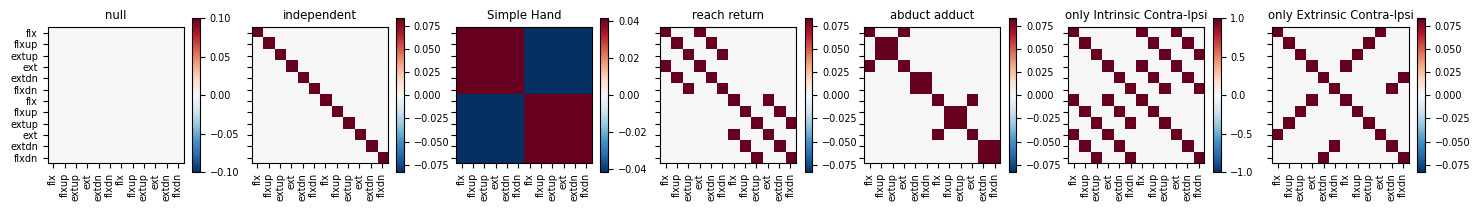

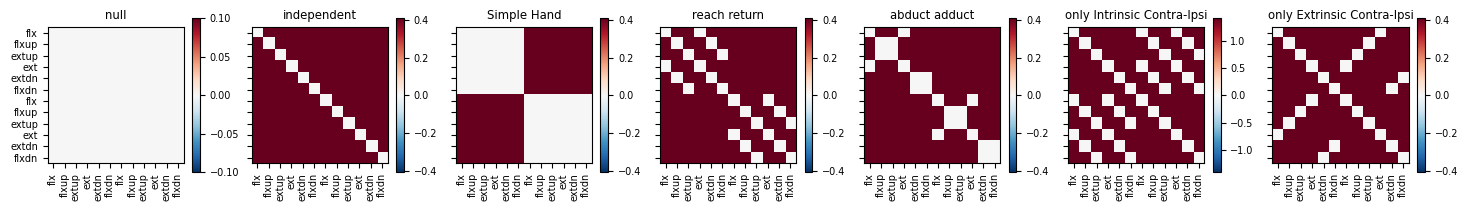

In [174]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# ================ Fixed models ================
# Null model - no information:
cov = np.zeros((ncond, ncond))
M_null = pcm.FixedModel('null', cov)
M.append(M_null)

# indepdent model
cov = np.eye(ncond)
cov = cov/np.trace(np.eye(ncond))
M_indep = pcm.FixedModel('independent', cov)
M.append(M_indep)

# Which Hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov[6:12, 6:12] = 1
cov = cov / np.trace(cov)
# double center:
cov = cov - np.mean(cov, axis=0) - np.mean(cov, axis=1) + np.mean(cov)
M_hand = pcm.FixedModel('Simple Hand', cov)
M.append(M_hand)
modelG['Simple Hand'] = [cov]

# within hand structure:
# ceil_model = pcm.FreeModel('ceil', 6)
# contra_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unicontra_CVceiling_{region}.pkl'))
# theta_cv = contra_fit['theta_cv']
# params = theta_cv[-1]
# params = np.mean(params, axis=1)
# G_ceil_contra = ceil_model.predict(params[:ceil_model.n_param])[0]

# ipsi_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_uniipsi_CVceiling_{region}.pkl'))
# theta_cv = ipsi_fit['theta_cv']
# params = theta_cv[-1]
# params = np.mean(params, axis=1)
# G_ceil_ipsi = ceil_model.predict(params[:ceil_model.n_param])[0]

covs = np.tile(np.eye(3), (2,2))
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = covs
cov[6:12, 6:12] = covs
cov = cov / np.trace(cov)
M_contra_ipsi = pcm.FixedModel('reach return', cov)
M.append(M_contra_ipsi)
modelG['reach return'] = [cov]

# abduct - adduct model:
covs = np.eye(6)
covs[0,3] = 1
covs[1,2] = 1
covs[2,1] = 1
covs[3,0] = 1
covs[4,5] = 1
covs[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = covs
cov[6:12, 6:12] = covs
cov = cov / np.trace(cov)
M_contra_ipsi = pcm.FixedModel('abduct adduct', cov)
M.append(M_contra_ipsi)
modelG['abduct adduct'] = [cov]

# Intrinsic Contra-Ipsi model:
# cov = modelG['reach return'][0].copy()
cov = np.eye((ncond))
tmp = np.tile(np.eye(3), (2,2))
cov[0:6, 6:12] = tmp
cov[6:12, 0:6] = tmp
# cov = cov / np.trace(cov)
M_intrinsic = pcm.FixedModel('only Intrinsic Contra-Ipsi', cov)
M.append(M_intrinsic)
modelG['Intrinsic Contra-Ipsi'] = [cov]

# Extrinsic Contra-Ipsi model:
cov = np.eye(ncond)
cov[0,9] = 1
cov[1,8] = 1
cov[2,7] = 1
cov[3,6] = 1
cov[4,11] = 1
cov[5,10] = 1
# symmetrize:
cov = cov + cov.T - np.eye(ncond)
cov = cov / np.trace(cov)
M_extrinsic = pcm.FixedModel('only Extrinsic Contra-Ipsi', cov)
M.append(M_extrinsic)
modelG['Extrinsic Contra-Ipsi'] = [cov]

# ================ components models ================
# Simple hand + reach return structure:
M.append(pcm.ComponentModel('SimpleHand+ReachReturn', [modelG['Simple Hand'][0], modelG['reach return'][0]]))

# Simple hand + abduct adduct structure:
M.append(pcm.ComponentModel('SimpleHand+AbductAdduct', [modelG['Simple Hand'][0], modelG['abduct adduct'][0]]))

# Simple hand + abduct adduct structure:
M.append(pcm.ComponentModel('SimpleHand+Intrinsic', [modelG['Simple Hand'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

# Simple hand + extrinsic structure:
M.append(pcm.ComponentModel('SimpleHand+Extrinsic', [modelG['Simple Hand'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# Simple hand + reach return + abduct adduct structure:
M.append(pcm.ComponentModel('SimpleHand+ReachReturn+AbductAdduct', [modelG['Simple Hand'][0], modelG['reach return'][0], modelG['abduct adduct'][0]]))

# Simple hand + reach return structure + abduct adduct + Intrinsic:
M.append(pcm.ComponentModel('SimpleHand+ReachReturn+AbductAdduct+Intrinsic', [modelG['Simple Hand'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0]]))

# Simple hand + reach return structure + Extrinsic:
M.append(pcm.ComponentModel('SimpleHand+ReachReturn+AbductAdduct+Extrinsic', [modelG['Simple Hand'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# all models:
M.append(pcm.ComponentModel('SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic', [modelG['Simple Hand'][0], modelG['reach return'][0], modelG['abduct adduct'][0], modelG['Intrinsic Contra-Ipsi'][0], modelG['Extrinsic Contra-Ipsi'][0]]))

# ================ noise ceiling ================
# noise ceiling model:
# M_ceil = pcm.model.FreeModel('ceil',ncond)
RDMs = pd.read_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))
RDMs = RDMs[(RDMs['region']==region) & (RDMs['hem']=='L')]
RDMs = RDMs.G.values
G_avg = np.zeros((ncond,ncond))
for tmp in RDMs:
    G_avg += tmp/len(RDMs)
M_ceil = pcm.FixedModel('ceil', G_avg)
M.append(M_ceil)

# PLOT:
nmodels = len(M)
fix, ax = plt.subplots(1,7, figsize=(18,2), sharey=True)
for i in range(7):
    vmin = -np.max(np.abs(M[i].G))
    vmax = np.max(np.abs(M[i].G))
    ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,7, figsize=(18,2), sharey=True)
for i in range(7):
    D = pcm.G_to_dist(M[i].G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

 

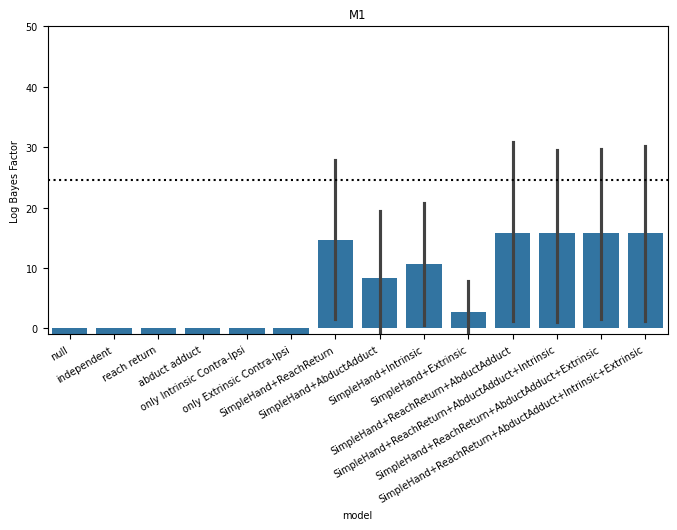

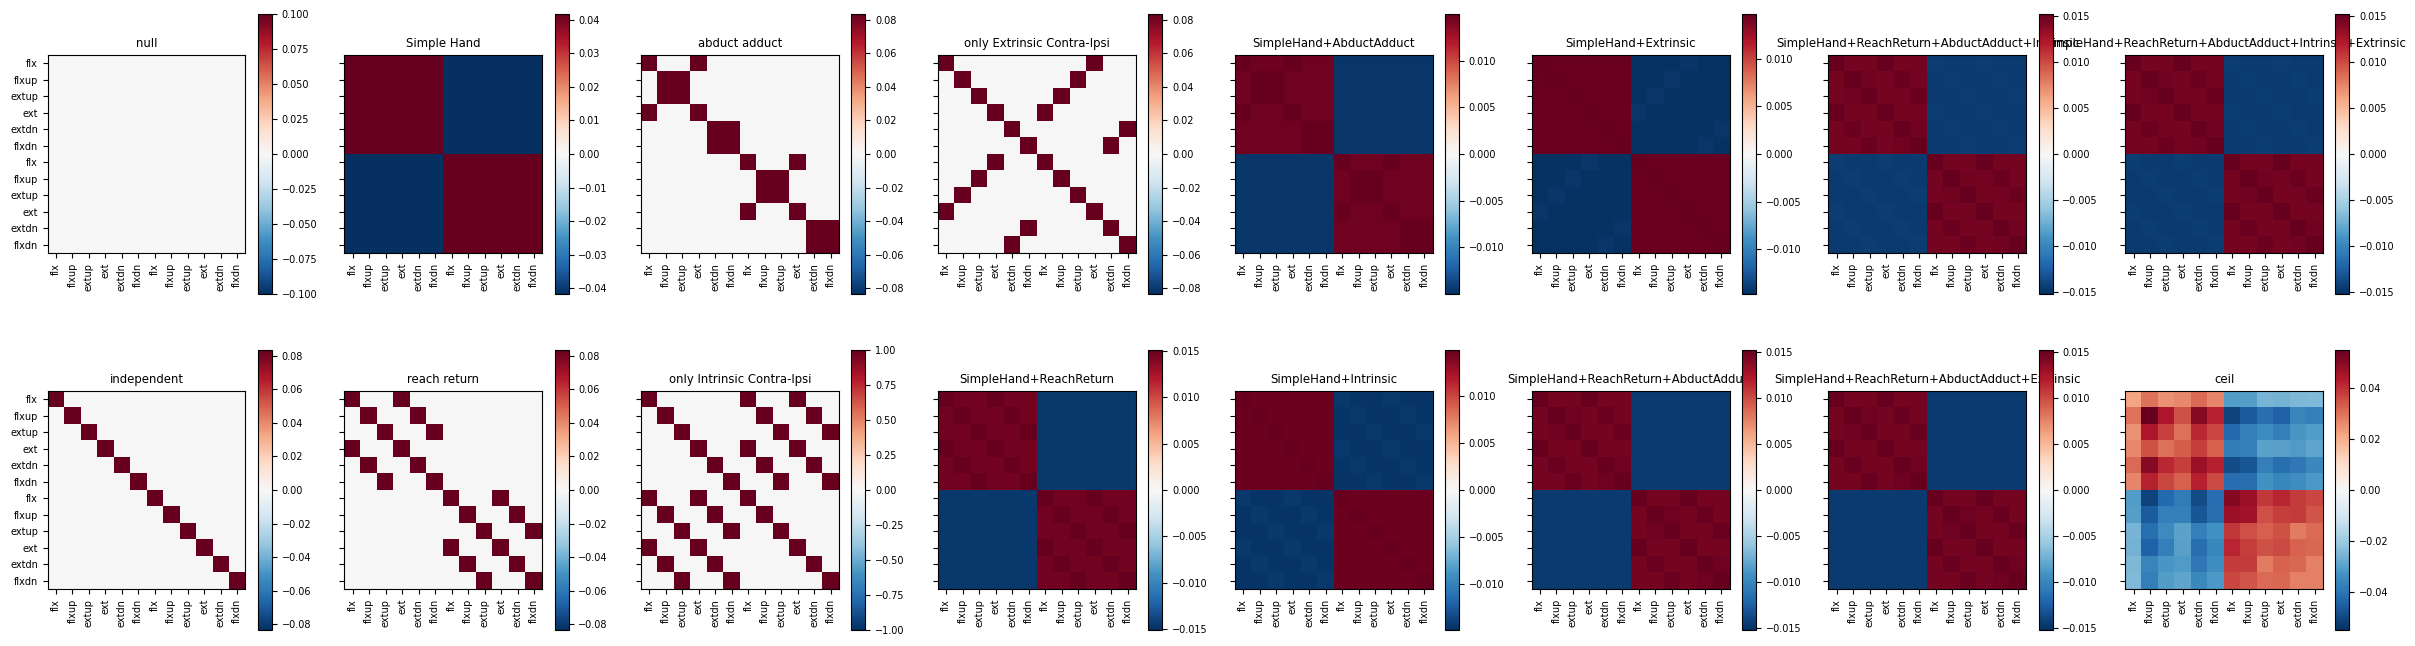

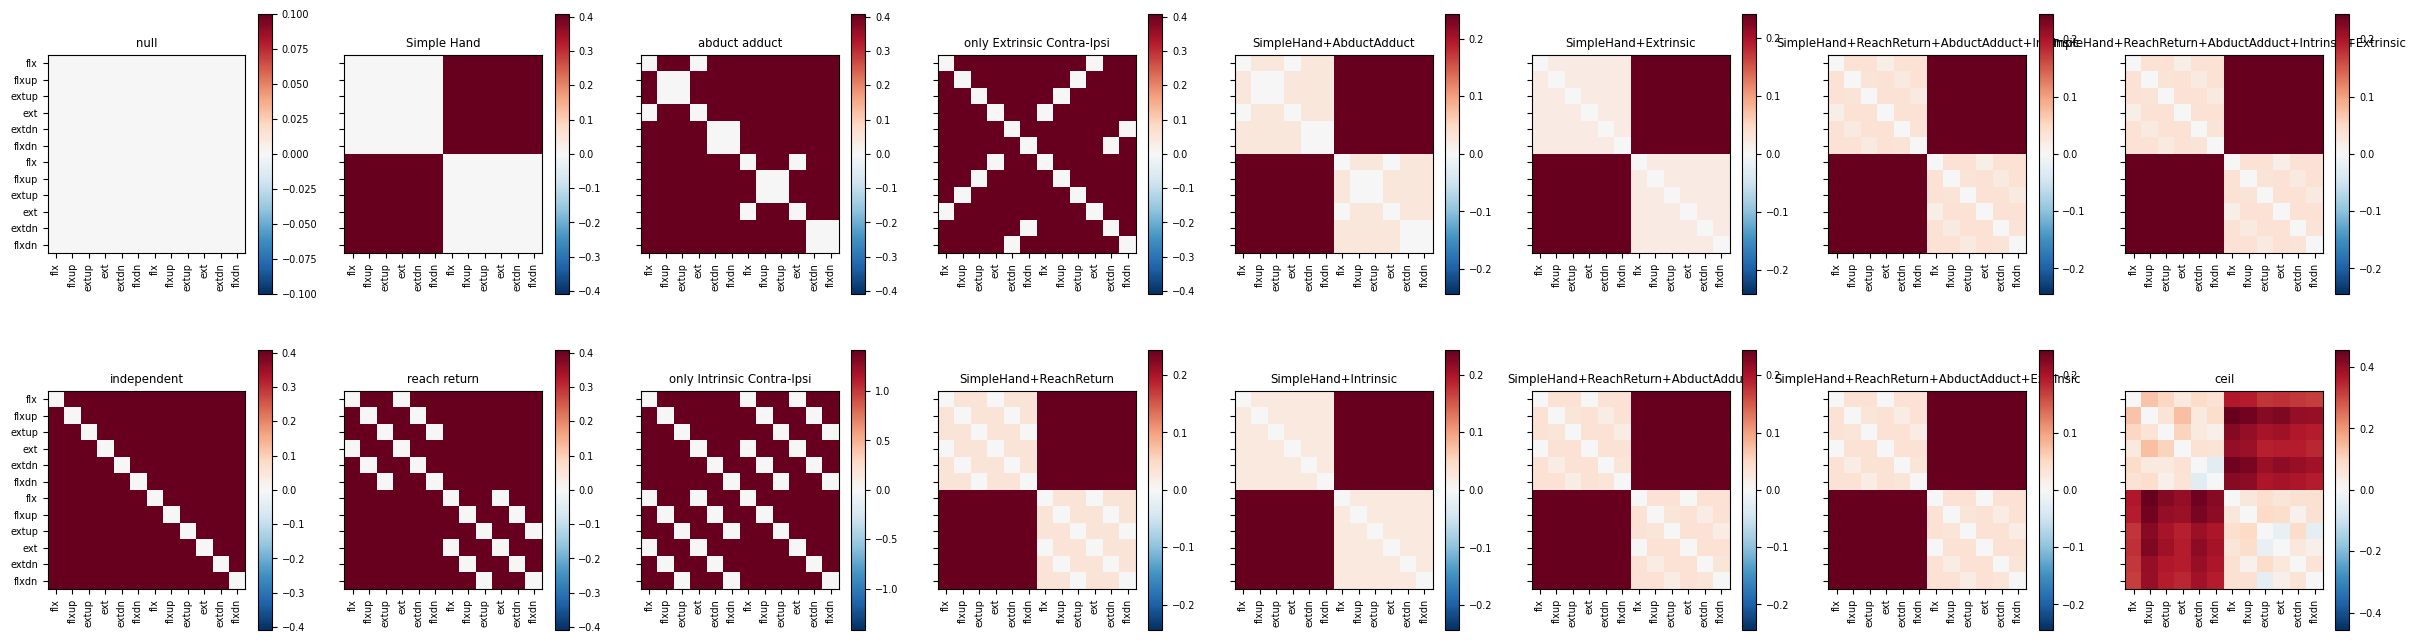

In [190]:
import pickle

region = 'M1'
plt.rcParams.update({'font.size': 7})

name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_12by12_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)

T_cv = results['T_cv']
theta_cv = results['theta_cv']
fig, ax = plt.subplots(1,1,figsize=(8,4))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'Simple Hand',
                        noise_ceiling= 'ceil')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{name}')
ax.set_ylim(-1, 50)
plt.show()

# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()

fig, ax = plt.subplots(2,nmodels//2, figsize=(30,8), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.show()




In [ ]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'V1'
name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_12by12_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# T-test between models:
from scipy import stats
likelihood = T_cv.likelihood
m_names = likelihood.columns.values
baseline = likelihood.loc[:,'Simple Hand'].values
likelihood = likelihood - baseline.reshape(-1,1)

bayesfact = {'SimpleHand+ReachReturn': [], 'SimpleHand+AbductAdduct': [], 'SimpleHand+Intrinsic': [], 'SimpleHand+Extrinsic': [], 'SimpleHand+ReachReturn+AbductAdduct': [], 'SimpleHand+ReachReturn+AbductAdduct+Intrinsic': [], 'SimpleHand+ReachReturn+AbductAdduct+Extrinsic': [], 'SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic': []}
bayesfact['SimpleHand+ReachReturn'] = likelihood['SimpleHand+ReachReturn'].values
bayesfact['SimpleHand+AbductAdduct'] = likelihood['SimpleHand+AbductAdduct'].values
bayesfact['SimpleHand+Intrinsic'] = likelihood['SimpleHand+Intrinsic'].values
bayesfact['SimpleHand+Extrinsic'] = likelihood['SimpleHand+Extrinsic'].values
bayesfact['SimpleHand+ReachReturn+AbductAdduct'] = likelihood['SimpleHand+ReachReturn+AbductAdduct'].values
bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'] = likelihood['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'].values
bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'] = likelihood['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'].values
bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] = likelihood['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'].values

# ttest each model >0:
ttests = {}
for k in bayesfact.keys():
    t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    mean = np.mean(bayesfact[k])
    std = np.std(bayesfact[k])
    sem = stats.sem(bayesfact[k])
    ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

# Model comparisons:
t, p = stats.ttest_rel(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'], bayesfact['SimpleHand+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic']) - 1
print('\nModel comparison:')
print(f'Paired t-test full_within+Intrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'], bayesfact['SimpleHand+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Extrinsic']) - 1
print(f'Paired t-test full_within+Extrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

t, p = stats.ttest_rel(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'], bayesfact['SimpleHand+ReachReturn+AbductAdduct'], alternative='greater')
mean_diff = np.mean(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
std_diff = np.std(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
sem_diff = stats.sem(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic'] - bayesfact['SimpleHand+ReachReturn+AbductAdduct'])
dof = len(bayesfact['SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic']) - 1
print(f'Paired t-test full_within+Intrinsic+Extrinsic vs full_within: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')




SimpleHand+ReachReturn: t(23)=3.44, p=0.0011, mean=142.41 std=198.78 sem=41.45
SimpleHand+AbductAdduct: t(23)=4.20, p=0.0002, mean=335.89 std=383.69 sem=80.00
SimpleHand+Intrinsic: t(23)=5.11, p=0.0000, mean=330.18 std=309.88 sem=64.61
SimpleHand+Extrinsic: t(23)=4.26, p=0.0001, mean=294.32 std=331.16 sem=69.05
SimpleHand+ReachReturn+AbductAdduct: t(23)=4.12, p=0.0002, mean=357.36 std=415.52 sem=86.64
SimpleHand+ReachReturn+AbductAdduct+Intrinsic: t(23)=4.80, p=0.0000, mean=414.40 std=414.09 sem=86.34
SimpleHand+ReachReturn+AbductAdduct+Extrinsic: t(23)=4.33, p=0.0001, mean=409.74 std=453.91 sem=94.65
SimpleHand+ReachReturn+AbductAdduct+Intrinsic+Extrinsic: t(23)=4.72, p=0.0000, mean=439.27 std=446.52 sem=93.11

Model comparison:
Paired t-test full_within+Intrinsic vs full_within: t(23)=3.45, p=0.0011, mean_diff=57.05 std_diff=79.34 sem_diff=16.54
Paired t-test full_within+Extrinsic vs full_within: t(23)=3.51, p=0.0010, mean_diff=52.38 std_diff=71.66 sem_diff=14.94
Paired t-test full_w